# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.  

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении имеется набор фотографий людей с указанием возраста.

**План**
- Провести исследовательский анализ набора фотографий
- Подготовить данные к обучению 
- Обучить нейронную сеть
- Рассчитать её качество

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Записи в таблице отсортированны по имени файла.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные состоят из 2-х столбцов с названием файла-картинки и разметки возраста. Названия - текстового формата, возраст - числового. Всего 7591 шт. записей. Объектов для обучения мало, стоит применить аугментацию и увеличить количество объектов

In [35]:
labels.nunique()

file_name    7591
real_age       97
dtype: int64

97 уникальных значений в столбце возраста. Не 100

In [5]:
labels.duplicated().sum()

0

Дубликаты отсутствуют

In [6]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

Пропуски отсутствуют

In [7]:
t = labels.pivot_table(index='real_age',
                   values='file_name',
                   aggfunc='count')

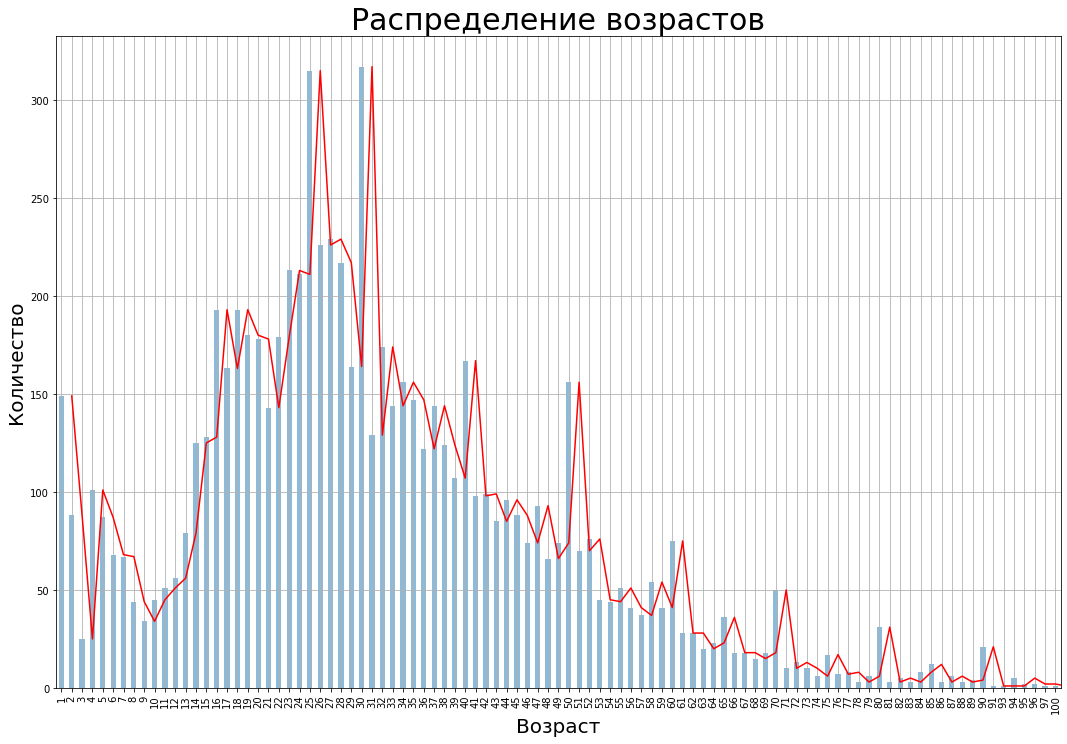

In [8]:
ti = t.plot(kind='bar', figsize=(18, 12), fontsize= 10, grid=True, legend=False, alpha=0.5)
ti.set_title('Распределение возрастов',fontsize = 30)
ti.set_xlabel('Возраст',fontsize = 20)
ti.set_ylabel('Количество',fontsize = 20)
ti.plot(t, alpha=1, color='red');

Большее количество фотографий сосредоточены в диапазоне возраста от 12 до 52

In [9]:
datagen = ImageDataGenerator(rescale=1./255)

In [10]:
datagen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                           directory = '/datasets/faces/final_files/',
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='raw',
                                           seed=42)

Found 7591 validated image filenames.


Количество фото соответствует количеству записей в таблице

In [33]:
features, target = next(datagen_flow)

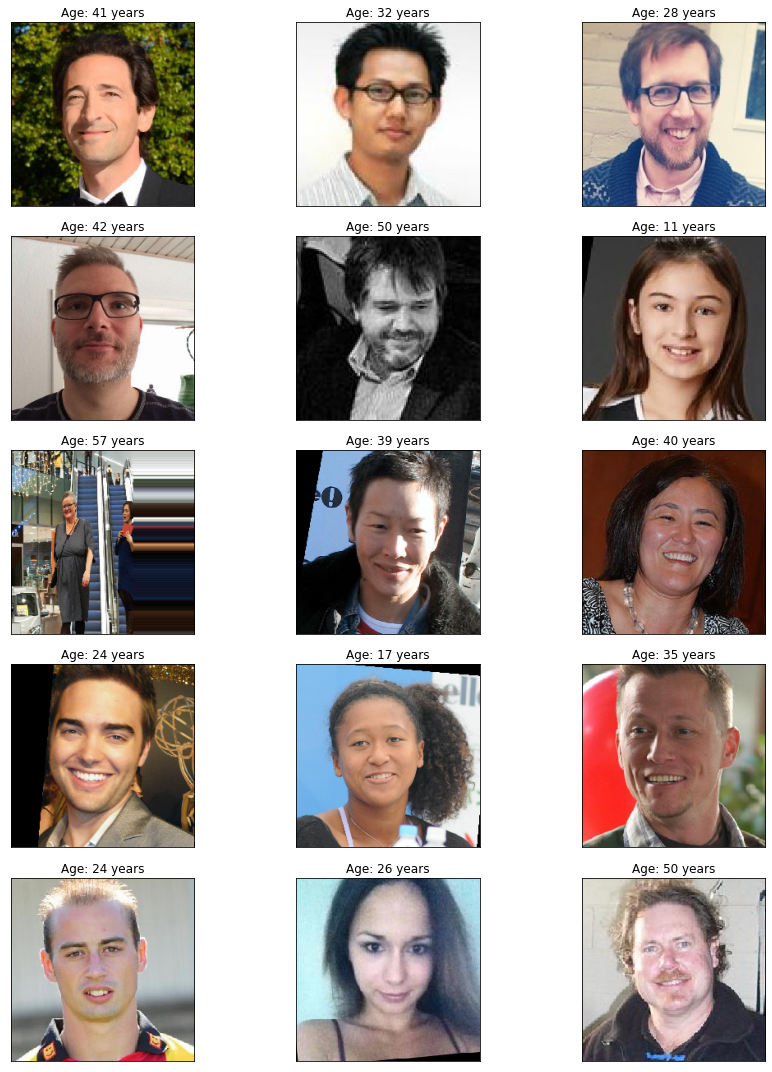

In [34]:
fig = plt.figure(figsize=(15,15))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]} years')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Судя по некоторым фото была проведена подготовка датасета - с помощью алгоритмов определенены лица и вырезаны из фото, сделана попытка выравнивания. Возраст соответствует.

### Вывод

Данные проверены. Состояние хорошее. Дубликатов, пропусков не обнаружено. Обнаружена обработка фотографий. Возраст распределен от 1 до 100, но наибольшее скопление образцов наблюдается на промежутке от 12 до 52 лет. Большинство фотографий фронтальные и выровнены по горизонтали, редкие не могут быть информативными из-за ошибки алгоритма обработки, некоторые смазаны по краям, встречаются черно-белые. Количество данных недостаточное для обучения, нужно провести аугментацию. В связи с вышеописаным, считаю что в аугментацию нужно включить:
- отражение по горизонтали - horizontal_flip
- вращение по горизонтали на 45 градусов - rotation_range 

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 

def load_train(path):
    labels = pd.read_csv(path+'/labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split = 0.25,
                                      rotation_range=45,
                                      horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory = path+'/final_files',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=42)
    return train_datagen_flow 

def load_test(path):
    labels = pd.read_csv(path+'/labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split = 0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory = path+'/final_files',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=42)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.00001)
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False) 
    
        
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data,
                test_data, batch_size=None, epochs=50,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,    
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model 

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.
 
Train for 178 steps, validate for 60 steps
Epoch 1/50
178/178 - 130s - loss: 799.9968 - mae: 23.6756 - val_loss: 1165.7715 - val_mae: 29.6162
Epoch 2/50
178/178 - 99s - loss: 251.3641 - mae: 12.2998 - val_loss: 1165.7452 - val_mae: 29.6160
Epoch 3/50
178/178 - 97s - loss: 137.7375 - mae: 8.8125 - val_loss: 1006.8817 - val_mae: 26.9873
Epoch 4/50
178/178 - 92s - loss: 105.6259 - mae: 7.7592 - val_loss: 230.4834 - val_mae: 11.1234
Epoch 5/50
178/178 - 93s - loss: 89.0004 - mae: 7.1390 - val_loss: 111.1672 - val_mae: 7.9341
Epoch 6/50
178/178 - 101s - loss: 80.8601 - mae: 6.8124 - val_loss: 90.9249 - val_mae: 7.2171
Epoch 7/50
178/178 - 98s - loss: 71.0085 - mae: 6.4542 - val_loss: 93.7344 - val_mae: 7.3640
Epoch 8/50
178/178 - 103s - loss: 68.1806 - mae: 6.2393 - val_loss: 88.0147 - val_mae: 7.0212
Epoch 9/50
178/178 - 103s - loss: 61.3180 - mae: 5.9719 - val_loss: 88.8861 - val_mae: 6.9803
Epoch 10/50
178/178 - 103s - loss: 57.4056 - mae: 5.8140 - val_loss: 92.5034 - val_mae: 7.3057
Epoch 11/50
178/178 - 103s - loss: 52.6397 - mae: 5.5357 - val_loss: 83.4930 - val_mae: 6.8147
Epoch 12/50
178/178 - 97s - loss: 49.7514 - mae: 5.4667 - val_loss: 83.2114 - val_mae: 6.8343
Epoch 13/50
178/178 - 95s - loss: 47.1313 - mae: 5.2821 - val_loss: 85.9313 - val_mae: 6.9692
Epoch 14/50
178/178 - 95s - loss: 44.6668 - mae: 5.1560 - val_loss: 81.3366 - val_mae: 6.7106
Epoch 15/50
178/178 - 98s - loss: 40.7074 - mae: 4.9737 - val_loss: 93.2099 - val_mae: 7.2377
Epoch 16/50
178/178 - 97s - loss: 38.2861 - mae: 4.7970 - val_loss: 83.3680 - val_mae: 6.7376
Epoch 17/50
178/178 - 97s - loss: 37.5879 - mae: 4.6970 - val_loss: 82.7374 - val_mae: 6.8216
Epoch 18/50
178/178 - 101s - loss: 35.3539 - mae: 4.6117 - val_loss: 81.2546 - val_mae: 6.7016
Epoch 19/50
178/178 - 100s - loss: 33.7670 - mae: 4.4830 - val_loss: 83.6782 - val_mae: 6.7711
Epoch 20/50
178/178 - 99s - loss: 31.9878 - mae: 4.3593 - val_loss: 81.0771 - val_mae: 6.6924
Epoch 21/50
178/178 - 100s - loss: 31.0757 - mae: 4.3443 - val_loss: 79.6350 - val_mae: 6.6233
Epoch 22/50
178/178 - 100s - loss: 30.2130 - mae: 4.2731 - val_loss: 78.9983 - val_mae: 6.5686
Epoch 23/50
178/178 - 98s - loss: 29.0807 - mae: 4.1643 - val_loss: 82.7985 - val_mae: 6.8602
Epoch 24/50
178/178 - 100s - loss: 27.8665 - mae: 4.0812 - val_loss: 76.8198 - val_mae: 6.5622
Epoch 25/50
178/178 - 99s - loss: 26.2817 - mae: 3.9794 - val_loss: 86.3471 - val_mae: 7.0244
Epoch 26/50
178/178 - 99s - loss: 26.1305 - mae: 3.9706 - val_loss: 78.4091 - val_mae: 6.5759
Epoch 27/50
178/178 - 100s - loss: 25.1681 - mae: 3.9011 - val_loss: 79.0937 - val_mae: 6.6596
Epoch 28/50
178/178 - 99s - loss: 24.0130 - mae: 3.7910 - val_loss: 77.8434 - val_mae: 6.6304
Epoch 29/50
178/178 - 100s - loss: 22.9850 - mae: 3.7407 - val_loss: 77.0600 - val_mae: 6.5890
Epoch 30/50
178/178 - 99s - loss: 22.2932 - mae: 3.6882 - val_loss: 77.0738 - val_mae: 6.6323
Epoch 31/50
178/178 - 100s - loss: 21.0727 - mae: 3.5610 - val_loss: 76.4460 - val_mae: 6.4934
Epoch 32/50
178/178 - 93s - loss: 21.5471 - mae: 3.5903 - val_loss: 82.0789 - val_mae: 6.9020
Epoch 33/50
178/178 - 98s - loss: 20.9091 - mae: 3.5174 - val_loss: 76.8814 - val_mae: 6.5809
Epoch 34/50
178/178 - 94s - loss: 19.5212 - mae: 3.4587 - val_loss: 75.3507 - val_mae: 6.4439
Epoch 35/50
178/178 - 97s - loss: 19.0265 - mae: 3.3682 - val_loss: 75.4537 - val_mae: 6.3787
Epoch 36/50
178/178 - 98s - loss: 18.3046 - mae: 3.3351 - val_loss: 76.0249 - val_mae: 6.4542
Epoch 37/50
178/178 - 98s - loss: 16.8079 - mae: 3.1892 - val_loss: 73.0236 - val_mae: 6.3608
Epoch 38/50
178/178 - 98s - loss: 16.6537 - mae: 3.1604 - val_loss: 75.3006 - val_mae: 6.5512
Epoch 39/50
178/178 - 92s - loss: 16.1481 - mae: 3.1078 - val_loss: 74.7339 - val_mae: 6.4920
Epoch 40/50
178/178 - 92s - loss: 15.8597 - mae: 3.0624 - val_loss: 72.5013 - val_mae: 6.4374
Epoch 41/50
178/178 - 95s - loss: 14.8324 - mae: 2.9964 - val_loss: 71.6084 - val_mae: 6.3067
Epoch 42/50
178/178 - 103s - loss: 14.4007 - mae: 2.9600 - val_loss: 74.3891 - val_mae: 6.4848
Epoch 43/50
178/178 - 99s - loss: 13.7658 - mae: 2.8821 - val_loss: 76.0478 - val_mae: 6.4542
Epoch 44/50
178/178 - 98s - loss: 13.1713 - mae: 2.8125 - val_loss: 74.9332 - val_mae: 6.4351
Epoch 45/50
178/178 - 101s - loss: 12.2670 - mae: 2.6975 - val_loss: 73.4292 - val_mae: 6.3736
Epoch 46/50
178/178 - 94s - loss: 11.0297 - mae: 2.5769 - val_loss: 73.2212 - val_mae: 6.5019
Epoch 47/50
178/178 - 94s - loss: 11.1438 - mae: 2.5893 - val_loss: 73.4774 - val_mae: 6.4438
Epoch 48/50
178/178 - 93s - loss: 11.2077 - mae: 2.5894 - val_loss: 69.6301 - val_mae: 6.3099
Epoch 49/50
178/178 - 92s - loss: 10.8121 - mae: 2.5452 - val_loss: 73.8474 - val_mae: 6.3856
Epoch 50/50
178/178 - 97s - loss: 10.3796 - mae: 2.4917 - val_loss: 71.6265 - val_mae: 6.4140
60/60 - 11s - loss: 71.6265 - mae: 6.4140
Test MAE: 6.4140

```

## Анализ обученной модели

При обучении применялась модель ResNet50 без верхушки с оптимизатором Adam(learning rate - 0.00001), функцией потерь MSE, загрузчиком данных ImageDataGenerator. В результате обучения модели на 50-ти эпохах средняя абсолютная ошибка составила 6.41 лет, что соответствует требованиям задачи. Возможно при увеличении количества эпох метрика улучшится еще больше.